In [1]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("linear_model.txt",delimiter='\t',header=None)
data.columns=['x','y','dy']

In [3]:
def f(x,a,b):
    return a*np.cos(x)+b
popt, pcov = curve_fit(f,data['x'].values,data['y'].values,p0=[2,2],sigma=data['dy'].values)

In [4]:
model = sp.CmdStanModel(stan_file='./stan_file.stan')
print(model.code())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/jakob/Documents/Studium/master_thesis/bayes/stan_file


data {
	int<lower=0> n;
  	vector[n] x;
  	vector[n] y;
	vector[n] dy;
}
parameters {
  	real a;
  	real b;
}

model {
	y ~ normal(b + a * cos(x), dy);
  	a ~ normal(0,100);
  	b ~ normal(0,100);
}



In [5]:
stan_data={'n':len(data['x'].values),
             'x':list(data['x'].values),
             'y':list(data['y'].values),
           'dy':list(data['dy'].values)
}

fit = model.sample(data=stan_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


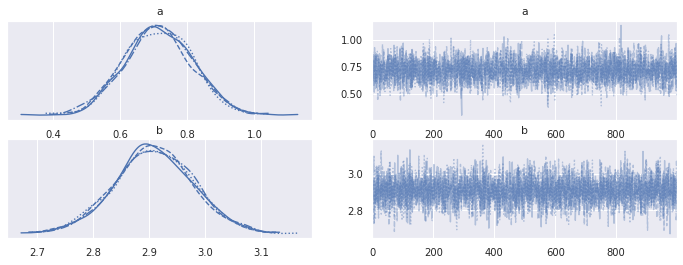

In [6]:
%%capture --no-display
warnings.filterwarnings('ignore')
az.plot_trace(fit)
plt.show()

In [7]:
summary=az.summary(fit)
samples=fit.draws_pd()
lower_a,upper_a = np.quantile(samples['a'],[0.025,0.975])
lower_b,upper_b = np.quantile(samples['b'],[0.025,0.975])


In [8]:
trace_thing=[]
for i in range(len(samples)):
    trace_thing.append(f(data['x'],samples['a'][i],samples['b'][i]))
    
lower_f=f(data['x'],lower_a,lower_b)
upper_f=f(data['x'],upper_a,upper_b)

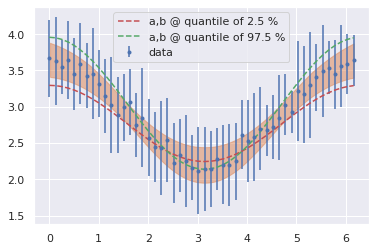

In [9]:
plt.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='data')
plt.plot(data['x'],lower_f,'r--',label='a,b @ quantile of 2.5 %')
plt.plot(data['x'],upper_f,'g--',label='a,b @ quantile of 97.5 %')
az.plot_hdi(data['x'].values,trace_thing,hdi_prob=.95)
plt.legend()
plt.show()

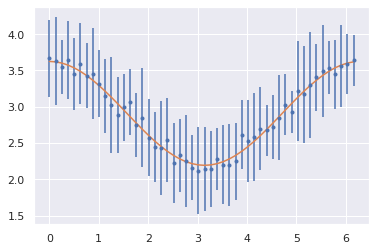

array([0.7158152 , 2.90910924])

In [10]:
yfit=f(data['x'],*popt)
plt.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.')
plt.plot(data['x'],yfit)
plt.show()
popt

In [11]:
print(fit.summary)

<bound method CmdStanMCMC.summary of CmdStanMCMC: model=stan_file chains=4['method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 csv_files:
	/tmp/tmp_s4ajep_/stan_file-202111301540-1-5p7jl_tg.csv
	/tmp/tmp_s4ajep_/stan_file-202111301540-2-vxcspytd.csv
	/tmp/tmp_s4ajep_/stan_file-202111301540-3-c8w7lt1w.csv
	/tmp/tmp_s4ajep_/stan_file-202111301540-4-2ass0ypd.csv
 output_files:
	/tmp/tmp_s4ajep_/stan_file-202111301540-1-5p7jl_tg-stdout.txt
	/tmp/tmp_s4ajep_/stan_file-202111301540-2-vxcspytd-stdout.txt
	/tmp/tmp_s4ajep_/stan_file-202111301540-3-c8w7lt1w-stdout.txt
	/tmp/tmp_s4ajep_/stan_file-202111301540-4-2ass0ypd-stdout.txt>
